# Mini-projet Machine learning avec MLLIB

Le problème de prédiction de l'attrition des employés consiste à prédire si un employé quittera ou non son poste. Cela peut être utile pour les entreprises afin de prendre des mesures préventives pour retenir leurs employés précieux et réduire le taux d'attrition. L'attrition peut être coûteuse pour les entreprises en termes de recrutement et de formation de nouveaux employés, ainsi que de la perte de connaissances et d'expertise. L'utilisation de Spark MLLIB permet de construire des modèles prédictifs à grande échelle pour résoudre ce problème. En utilisant des techniques telles que l'encodage des caractéristiques, la visualisation des données et la construction de modèles Random Forests et Gradient Boosting, les data scientists peuvent développer des modèles prédictifs précis qui peuvent aider les entreprises à réduire le taux d'attrition et à améliorer la rétention des employés.

# 1. Dataset :*Attrition et performance des employés IBM HR Analytics Prévoyez l'attrition de vos précieux employés
Il s'agit d'un ensemble de données fictif créé par les data scientists d'IBM. Nous devons explorer l'ensemble de données, comprendre les algorithmes et les techniques qui peuvent y être appliqués. Nous essaierons d'obtenir des informations significatives à partir de l'ensemble de données, comme quels sont les facteurs qui ont un impact sur l'attrition des employés.

# 2. Travail demandé :

# 1. Importer les données : Tout d'abord, il est nécessaire d'importer les données dans un format exploitable par Spark MLLIB. Les données peuvent être stockées dans des fichiers CSV, des bases de données ou des formats de fichiers parquet, entre autres.

In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [51]:
spark = SparkSession.builder.appName("Employee Attrition Prediction").getOrCreate()

# Charger les données
data = spark.read.csv("HR-Employee-Attrition.csv", header=True, inferSchema=True)

# 2. Explorer les données : Une fois les données importées, il est important d'en explorer la structure et les caractéristiques. Cela peut inclure l'analyse des valeurs manquantes, des distributions de variables et de l'existence de corrélations entre les variables.




Affichage des 10 premières lignes
+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears

+-------+------------------+---------+--------------+------------------+---------------+----------------+------------------+----------------+-------------+-----------------+-----------------------+------+------------------+------------------+------------------+--------------------+------------------+-------------+-----------------+------------------+------------------+------+--------+------------------+-------------------+------------------------+-------------+------------------+------------------+---------------------+------------------+------------------+------------------+-----------------------+--------------------+
|summary|               Age|Attrition|BusinessTravel|         DailyRate|     Department|DistanceFromHome|         Education|  EducationField|EmployeeCount|   EmployeeNumber|EnvironmentSatisfaction|Gender|        HourlyRate|    JobInvolvement|          JobLevel|             JobRole|   JobSatisfaction|MaritalStatus|    MonthlyIncome|       MonthlyRate|NumCompaniesWorked|O

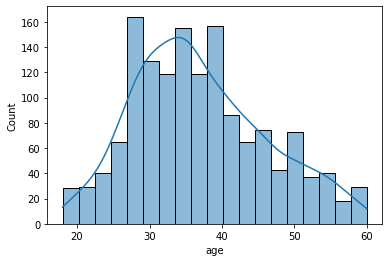




Matrice de corrélation entre Age et DailyRate
[[1.0, 0.010660942645538145], [0.010660942645538145, 1.0]]



Nuage de points de corrélation entre Age et DailyRate


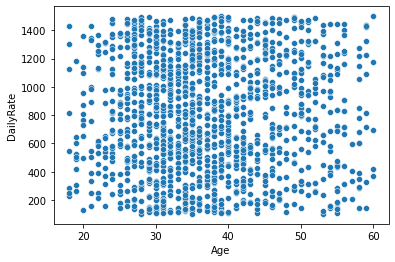

In [52]:
# Afficher les 10 premières lignes
print("\n\n")
print("Affichage des 10 premières lignes")
data.show(10)

# Afficher le schéma
print("\n\n")
print("Affichage du schéma")
data.printSchema()

# Statistiques descriptives
print("\n\n")
print("Statistiques descriptives")
data.describe().show()
print("\n\n")
data_summary = data.describe().toPandas()
print(data_summary)

# Vérification des valeurs manquantes
# Identifiecation des colonnes avec des valeurs manquantes
print("\n\n")
print("Valeurs manquantes par colonnes")
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()


# Analyse des distributions de variables
# Exemple avec age
print("\n\n")
print("Histogramme de distribution de la variable age")
col_name = "age"
col_data = data.select(col_name).toPandas()
sns.histplot(col_data[col_name], kde=True)
plt.show()


# Examiner les corrélations entre les variables et visualiser les relations
# Création d'un vecteur avec les colonnes numériques
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=["Age", "DailyRate"], outputCol=vector_col)
data_vector = assembler.transform(data).select(vector_col)

# Calculer la matrice de corrélation
matrix = Correlation.corr(data_vector, vector_col).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()
print("\n\n")
print("Matrice de corrélation entre Age et DailyRate")
print(correlation_matrix)

# Exemple pour un nuage de points entre deux variables numériques (Age, DailyRate)
x_col = "Age"
y_col = "DailyRate"
scatter_data = data.select(x_col, y_col).toPandas()
sns.scatterplot(data=scatter_data, x=x_col, y=y_col)
print("\n\n")
print("Nuage de points de corrélation entre Age et DailyRate")
plt.show()

# 3. Nettoyer les données : Après l'exploration des données, il est possible que certaines données soient incohérentes, mal formatées ou contiennent des valeurs aberrantes. Dans ce cas, il est important de nettoyer les données avant de les utiliser pour entraîner un modèle.

In [53]:
# On va supprimer les valeurs aberrantes les colonnes numériquesen utilisant l'intervalle interquartile (IQR).

# Liste des colonnes numériques
numerical_columns = ["Age", "DailyRate", "DistanceFromHome", "Education", "EnvironmentSatisfaction", "HourlyRate", "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating", "RelationshipSatisfaction", "StockOptionLevel", "TotalWorkingYears", "TrainingTimesLastYear", "WorkLifeBalance", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]

data_clean = data

for column in numerical_columns:
    Q1 = data.approxQuantile(column, [0.25], 0.05)[0]
    Q3 = data.approxQuantile(column, [0.75], 0.05)[0]
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR

    data_clean = data_clean.filter((col(column) >= lower_range) & (col(column) <= upper_range))

# 4. Préparer les données : Selon le modèle que vous souhaitez utiliser, vous devrez peut-être préparer les données pour le rendre compatible avec ce modèle. Cela peut inclure la normalisation des variables, la transformation des variables catégorielles en variables numériques et la séparation des données en ensembles de formation et de test.

In [54]:
# Normalisation de toutes les colonnes numériques et transformation des colonnes discrettes en variables numériques (one-hot encoding).

# Liste des colonnes discrétes
categorical_columns = ["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "OverTime"]

# Stages pour le pipeline
stages = []

# One-hot encoding pour les colonnes catégorielles
for column in categorical_columns:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}Index")
    encoder = OneHotEncoder(inputCol=f"{column}Index", outputCol=f"{column}Vec")
    stages += [indexer, encoder]

# VectorAssembler et MinMaxScaler pour les colonnes numériques
for column in numerical_columns:
    assembler = VectorAssembler(inputCols=[column], outputCol=f"{column}Vec")
    scaler = MinMaxScaler(inputCol=f"{column}Vec", outputCol=f"{column}Scaled")
    stages += [assembler, scaler]

# Créer et appliquer un pipeline
pipeline = Pipeline(stages=stages)
data_prepared = pipeline.fit(data_clean).transform(data_clean)

# 5. Sélectionner les fonctionnalités : Si les données contiennent de nombreuses variables, vous pouvez envisager de sélectionner les fonctionnalités qui sont les plus pertinentes pour votre modèle. Cela peut aider à améliorer la précision de votre modèle et à réduire le temps nécessaire pour l'entraîner.

In [55]:
# Utilisation méthode Chi-Squared pour sélectionner les fonctionnalités les plus pertinentes pour le modèle. Par exemple, pour sélectionner les 5 fonctionnalités les plus importantes parmi les colonnes discrétes et numériques prétraitées:

# Combinez toutes les colonnes d'entités en un seul vecteur
input_cols = [f"{col}Scaled" for col in numerical_columns] + [f"{col}Vec" for col in categorical_columns]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data_features = assembler.transform(data_prepared)

# Indexez la colonne Attrition (cible)
indexer = StringIndexer(inputCol="Attrition", outputCol="label")
data_features = indexer.fit(data_features).transform(data_features)

# Utilisation hiSqSelector pour sélectionner les fonctionnalités les plus pertinentes
selector = ChiSqSelector(numTopFeatures=5, featuresCol="features", outputCol="selectedFeatures", labelCol="label")
selected_data = selector.fit(data_features).transform(data_features)

print("\n\n")
print("Affichage dataset avec les fonctionnalités pertinentes")
selected_data.show()

23/04/30 23:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1066.0 KiB
23/04/30 23:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.1 KiB
23/04/30 23:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1070.1 KiB





Nouveau dataset


+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-------------------+-----------------+---------------+-------------+-------------------+-----------------+-----------+-------------+------------+-------------+------------------+----------------+-------------+-------------+------+--------------------+------------+--------------------+-------------------+----------------------+------------+---------------+--------------------------+-----------------------------+-------------+--------------------+-----------

# 6. Équilibrer les données : Si les données contiennent un déséquilibre entre les classes, il peut être nécessaire d'équilibrer les données en utilisant des techniques telles que SMOTE (Synthetic Minority Over-sampling Technique) pour augmenter le nombre d'échantillons de la classe minoritaire.

In [56]:
# Calculez le taux d'équilibrage
attrition_counts = data_features.groupBy("label").count().collect()
minority_count = min(attrition_counts, key=lambda x: x["count"])["count"]
majority_count = max(attrition_counts, key=lambda x: x["count"])["count"]
balancing_ratio = minority_count / majority_count

# Équilibrez les données
majority_label = max(attrition_counts, key=lambda x: x["count"])["label"]
minority_label = min(attrition_counts, key=lambda x: x["count"])["label"]

majority_data = data_features.filter(col("label") == majority_label)
minority_data = data_features.filter(col("label") == minority_label)

majority_data_downsampled = majority_data.sample(withReplacement=False, fraction=balancing_ratio, seed=42)
balanced_data = majority_data_downsampled.union(minority_data)

print("\n\n")
print("Affichage dataset équilibré")
balanced_data.show()

# 7. Diviser les données : Une fois que les données sont nettoyées et préparées, il est important de diviser les données en ensembles de formation et de test. L'ensemble de formation est utilisé pour entraîner le modèle, tandis que l'ensemble de test est utilisé pour évaluer les performances du modèle.

In [57]:
train_data, test_data = balanced_data.randomSplit([0.8, 0.2], seed=42)

# 8. Entraîner le modèle : Utilisez l'ensemble de formation pour entraîner le modèle en utilisant l'algorithme approprié. Les algorithmes populaires pour la classification incluent Random Forest, Gradient Boosting, Logistic Regression et Decision Tree.

In [59]:
# Random Forest
rf = RandomForestClassifier(featuresCol="selectedFeatures", labelCol="label", numTrees=100)
rf_model = rf.fit(train_data)


# Gradient Boosting
gbt = GBTClassifier(featuresCol="selectedFeatures", labelCol="label", maxIter=100)
gbt_model = gbt.fit(train_data)


# Logistic Regression:
lr = LogisticRegression(featuresCol="selectedFeatures", labelCol="label", maxIter=100)
lr_model = lr.fit(train_data)

# Decision Tree:
dt = DecisionTreeClassifier(featuresCol="selectedFeatures", labelCol="label")
dt_model = dt.fit(train_data)



# 9. Évaluer le modèle : Une fois que le modèle est entraîné, utilisez l'ensemble de test pour évaluer ses performances. Les métriques courantes pour évaluer les performances d'un modèle de classification incluent la précision, le rappel, le score F1 et la courbe ROC.

In [ ]:
# Random Forest
predictions_rf = rf_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator.evaluate(predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)


# Gradient Boosting
predictions_gbt = gbt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = evaluator.evaluate(predictions_gbt)
print("Gradient Boosting Accuracy:", accuracy_gbt)

# Logistic Regression:
predictions_lr = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator.evaluate(predictions_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

# Decision Tree:
predictions_dt = dt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator.evaluate(predictions_dt)
print("Decision Tree Accuracy:", accuracy_dt)


# 10. 

In [ ]:
# On peut utiliser CrossValidator et ParamGridBuilder pour optimiser les hyperparamètres de chaque modèle.
# Example avec RandomForest
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200])
             .addGrid(rf.maxDepth, [5, 10, 20])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cv_model = cv.fit(train_data)
best_rf_model = cv_model.bestModel


# 11. 

In [ ]:
# 